In [1]:
# Load the dataset from the uploaded file
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU
from tensorflow.keras.optimizers import SGD  # Import SGD optimizer
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [2]:
# Load the dataset into a dataframe
file_path = './data/GOOG.csv'
data = pd.read_csv(file_path)

# Create a new dataframe by removing the 'Adjusted Close' column
data_without_adjusted_close = data.drop(columns=['Adjusted Close'], errors='ignore')

In [3]:
# Check if there are any rows where 'Close' is greater than 'High'
invalid_close_high_rows = data_without_adjusted_close[data_without_adjusted_close['Close'] > data_without_adjusted_close['High']]

In [4]:
print("Rows where 'Close' is greater than 'High':")
print(invalid_close_high_rows)

Rows where 'Close' is greater than 'High':
Empty DataFrame
Columns: [Date, Low, Open, Volume, High, Close]
Index: []


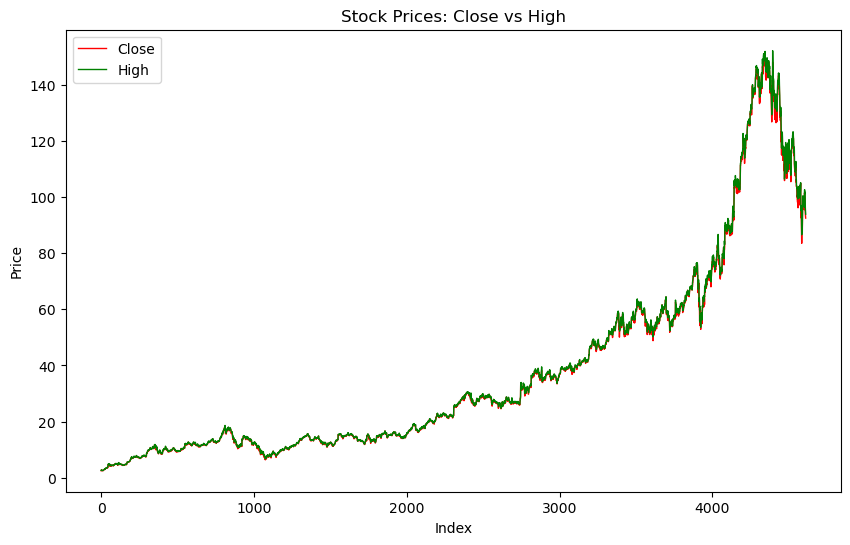

In [5]:
import matplotlib.pyplot as plt

# Plot 'Close' and 'High' values
plt.figure(figsize=(10, 6))
plt.plot(data_without_adjusted_close['Close'], label='Close', color='red', linewidth=1)
plt.plot(data_without_adjusted_close['High'], label='High', color='green', linewidth=1)

# Add title and labels
plt.title("Stock Prices: Close vs High")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

# Display the plot
plt.show()


In [6]:
data_without_adjusted_close.head()

,Date,Low,Open,Volume,High,Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104


In [7]:
data_without_adjusted_close.describe()

,Low,Open,Volume,High,Close
count,4612.000000,4612.000000,4.612000e+03,4612.000000,4612.000000
mean,37.088474,37.471847,1.238896e+08,37.856624,37.477273
std,34.791176,35.163155,1.536223e+08,35.549294,35.170034
min,2.390042,2.470490,1.584340e+05,2.534002,2.490913
25%,12.401765,12.575302,2.992850e+07,12.697718,12.576174
50%,22.808758,22.980115,6.869051e+07,23.098795,22.954461
75%,52.975875,53.578501,1.549155e+08,54.106961,53.534375
max,149.887497,151.863495,1.650833e+09,152.100006,150.709000


In [8]:
print(f"The entire data set length: {len(data_without_adjusted_close)}")

The entire data set length: 4612


In [9]:
# Parse the 'Date' column as datetime and set it as the index
data_without_adjusted_close['Date'] = pd.to_datetime(data_without_adjusted_close['Date'])
data_with_date_index = data_without_adjusted_close.set_index('Date')

# Define split proportions
train_size = 0.7  # 70% training
validation_size = 0.15  # 15% validation
test_size = 0.15  # 15% testing

# Get split indices
n = len(data_with_date_index)
train_end = int(train_size * n)
validation_end = int((train_size + validation_size) * n)

# Perform the splits
train_data = data_with_date_index.iloc[:train_end]
validation_data = data_with_date_index.iloc[train_end:validation_end]
test_data = data_with_date_index.iloc[validation_end:]

# Print sizes of the datasets after splitting
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(validation_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 3228
Validation set size: 692
Test set size: 692


/var/folders/hq/6dd_tz_n151_0rsqmh1krf4c0000gn/T/ipykernel_55633/3368692928.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_without_adjusted_close['Date'] = pd.to_datetime(data_without_adjusted_close['Date'])


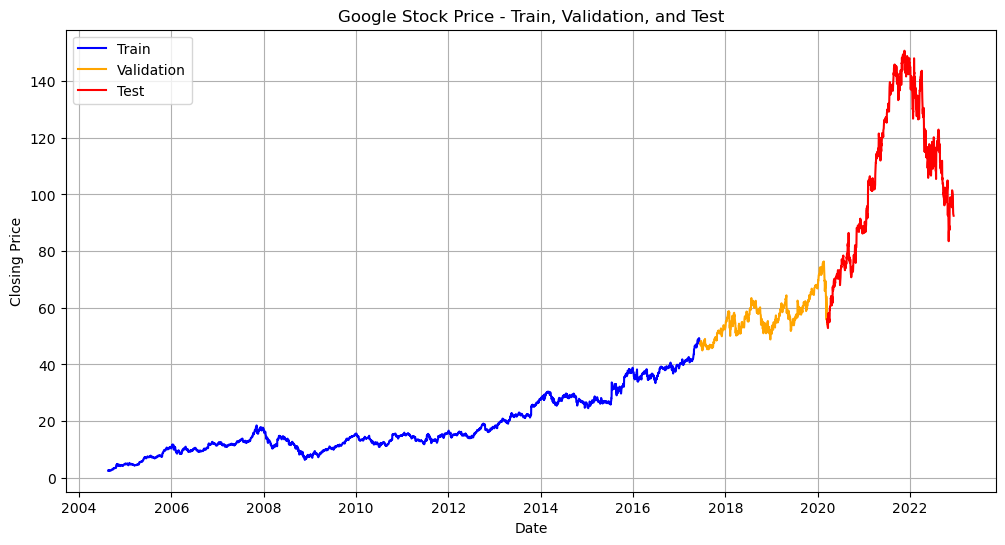

In [10]:
# Show the split dataset proportions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(validation_data.index, validation_data['Close'], label='Validation', color='orange')
plt.plot(test_data.index, test_data['Close'], label='Test', color='red')

# Adding labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Google Stock Price - Train, Validation, and Test')
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [11]:
# Separate predictors (X) and response variable (y) for each split
X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close'].values.reshape(-1, 1)

X_val = validation_data.drop(columns=['Close'])
y_val = validation_data['Close'].values.reshape(-1, 1)

X_test = test_data.drop(columns=['Close'])
y_test = test_data['Close'].values.reshape(-1, 1)

# Print sizes of the splits for verification
print(f"Training set - Predictors (X_train): {X_train.shape}, Response (y_train): {y_train.shape}")
print(f"Validation set - Predictors (X_val): {X_val.shape}, Response (y_val): {y_val.shape}")
print(f"Test set - Predictors (X_test): {X_test.shape}, Response (y_test): {y_test.shape}")

Training set - Predictors (X_train): (3228, 4), Response (y_train): (3228, 1)
Validation set - Predictors (X_val): (692, 4), Response (y_val): (692, 1)
Test set - Predictors (X_test): (692, 4), Response (y_test): (692, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize each split separately
train_normalized = scaler.fit_transform(train_data)
validation_normalized = scaler.transform(validation_data)
test_normalized = scaler.transform(test_data)

# Sequence generation function
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length][4]  
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets).reshape(-1, 1)

# Sequence length
sequence_length = 10

# Generate sequences for each split
X_train, y_train = create_sequences(train_normalized, sequence_length)
X_val, y_val = create_sequences(validation_normalized, sequence_length)
X_test, y_test = create_sequences(test_normalized, sequence_length)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3218, 10, 5), y_train shape: (3218, 1)
X_val shape: (682, 10, 5), y_val shape: (682, 1)
X_test shape: (682, 10, 5), y_test shape: (682, 1)


### Vanilla RNN

2024-12-05 23:00:55.014774: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-05 23:00:55.014806: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-05 23:00:55.014820: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-05 23:00:55.014967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-05 23:00:55.014979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/tusharbansal/anaconda3/envs/UML/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using 

Epoch 1/20


2024-12-05 23:00:55.640115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0731 - mae: 0.1651 - val_loss: 0.1479 - val_mae: 0.3468
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 8.3231e-04 - mae: 0.0196 - val_loss: 0.1056 - val_mae: 0.2875
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 4.4622e-04 - mae: 0.0140 - val_loss: 0.0740 - val_mae: 0.2336
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 2.9126e-04 - mae: 0.0112 - val_loss: 0.0576 - val_mae: 0.2014
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 2.1382e-04 - mae: 0.0102 - val_loss: 0.0466 - val_mae: 0.1779
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.8050e-04 - mae: 0.0095 - val_loss: 0.0394 - val_mae: 0.1600
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 1.6471e-04 - mae: 0.0090 - val_loss: 0.0331 - val_mae: 0.1433
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1.2810e-04 - mae: 0.0079 - val_loss: 0.0310 - val_mae: 0.1397
Epoch 9/20
101/101 ━━━━━━━━━━━━

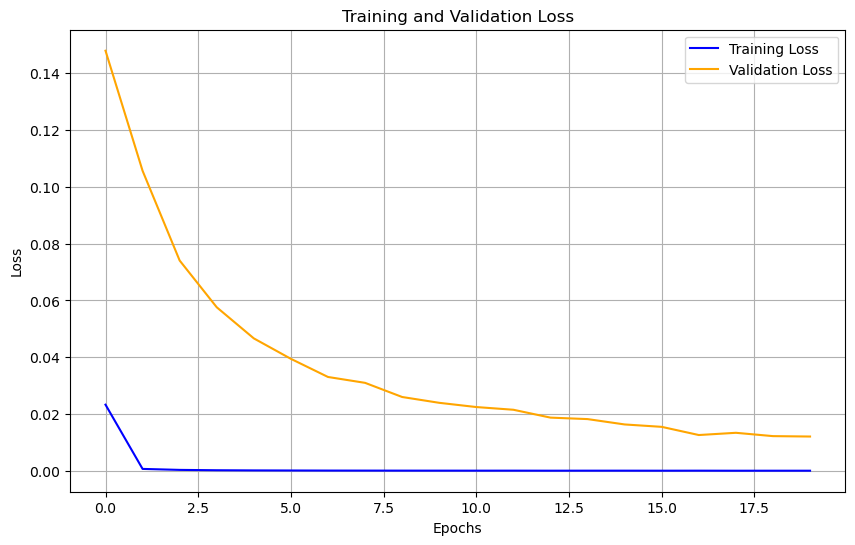

In [ ]:

class VanillaRNNModel:
    def __init__(self, input_shape):
        
        self.model = Sequential([
            SimpleRNN(32, activation='tanh', input_shape=input_shape),
            Dense(1)  
        ])
    
    def compile(self):
        
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
    
    def plot_loss(self):
        
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()


rnn_model = VanillaRNNModel(input_shape=(X_train.shape[1], X_train.shape[2]))
rnn_model.compile()
rnn_model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)


rnn_model.plot_loss()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Vanilla RNN Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 3.784845883545638
Mean Squared Error (MSE): 26.422839559705256
Root Mean Squared Error (RMSE): 5.140315122607295
R-squared (R2): 0.38076189983541975


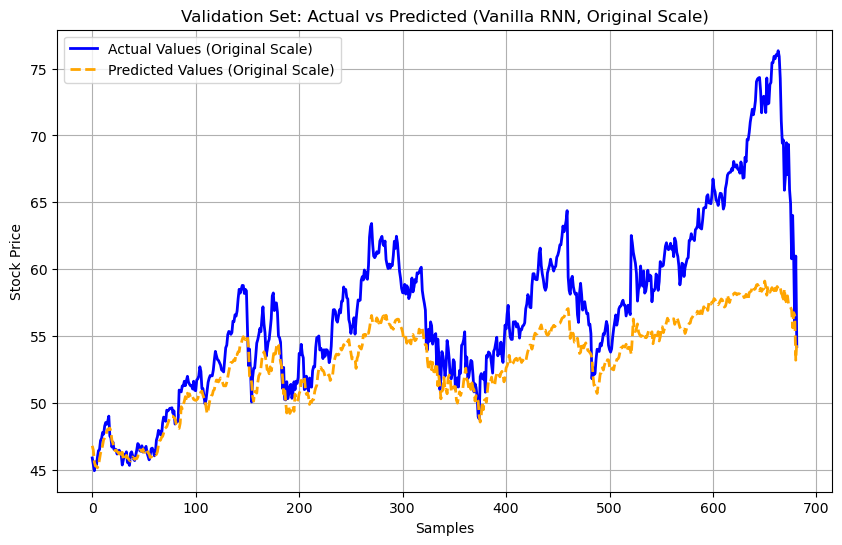

In [ ]:
y_val_pred_rnn = rnn_model.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_rnn_reshaped = y_val_pred_rnn.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped]))[:, -1]
y_val_pred_rnn_inv = scaler.inverse_transform(np.hstack([np.zeros_like(y_val_pred_rnn_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_rnn_reshaped]))[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_rnn_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_rnn_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_rnn_inv)

# Print metrics
print(f"Vanilla RNN Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_rnn_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (Vanilla RNN, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


### LSTM

Epoch 1/20


/Users/tusharbansal/anaconda3/envs/UML/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1026 - mae: 0.2035 - val_loss: 0.0183 - val_mae: 0.1168
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4392e-04 - mae: 0.0113 - val_loss: 0.0142 - val_mae: 0.1000
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3639e-04 - mae: 0.0111 - val_loss: 0.0138 - val_mae: 0.0988
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4555e-04 - mae: 0.0111 - val_loss: 0.0130 - val_mae: 0.0957
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1895e-04 - mae: 0.0107 - val_loss: 0.0123 - val_mae: 0.0930
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2733e-04 - mae: 0.0110 - val_loss: 0.0098 - val_mae: 0.0812
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1543e-04 - mae: 0.0108 - val_loss: 0.0110 - val_mae: 0.0883
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0769e-04 - mae: 0.0105 - val_loss: 0.0085 - val_mae: 0.0757
Epoch 9/20
101/101 ━━━━━━━━━━━━

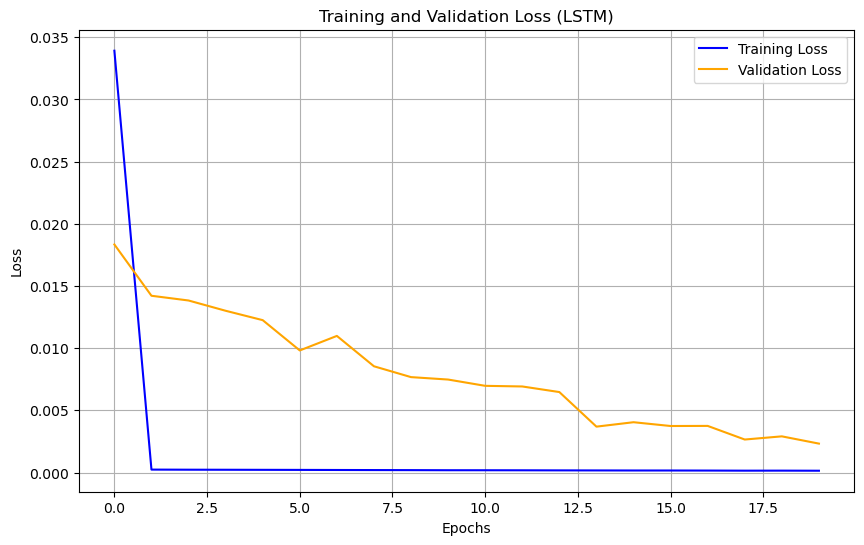

In [ ]:

class LSTMModel:
    def __init__(self, input_shape):
        
        self.model = Sequential([
            LSTM(32, activation='tanh', input_shape=input_shape, return_sequences=False),
            Dense(1)  
        ])
    
    def compile(self):
        
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
    
    def plot_loss(self):
        
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (LSTM)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()


lstm_model = LSTMModel(input_shape=(X_train.shape[1], X_train.shape[2]))
lstm_model.compile()
lstm_model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)


lstm_model.plot_loss()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 1.8012252539134095
Mean Squared Error (MSE): 5.0764480651547625
Root Mean Squared Error (RMSE): 2.2530974380072344
R-squared (R2): 0.8810298170888314


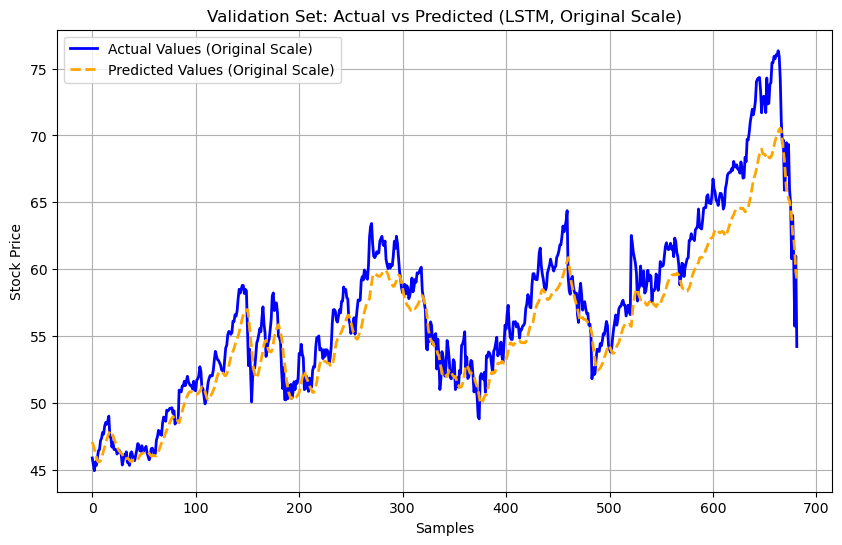

In [ ]:
y_val_pred_lstm = lstm_model.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_lstm_reshaped = y_val_pred_lstm.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped]))[:, -1]
y_val_pred_lstm_inv = scaler.inverse_transform(np.hstack([np.zeros_like(y_val_pred_lstm_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_lstm_reshaped]))[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_lstm_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_lstm_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_lstm_inv)

# Print metrics
print(f"LSTM Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_lstm_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (LSTM, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


### GRU 

Epoch 1/20


/Users/tusharbansal/anaconda3/envs/UML/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0152 - mae: 0.0756 - val_loss: 0.0051 - val_mae: 0.0622
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2173e-04 - mae: 0.0083 - val_loss: 0.0027 - val_mae: 0.0434
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.6652e-05 - mae: 0.0066 - val_loss: 0.0022 - val_mae: 0.0378
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.8221e-05 - mae: 0.0062 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8502e-05 - mae: 0.0063 - val_loss: 0.0019 - val_mae: 0.0356
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1928e-05 - mae: 0.0063 - val_loss: 0.0018 - val_mae: 0.0343
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.1725e-05 - mae: 0.0060 - val_loss: 0.0016 - val_mae: 0.0323
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.5595e-05 - mae: 0.0059 - val_loss: 0.0020 - val_mae: 0.0377
Epoch 9/20
101/101 ━━━━━━━━━━━━

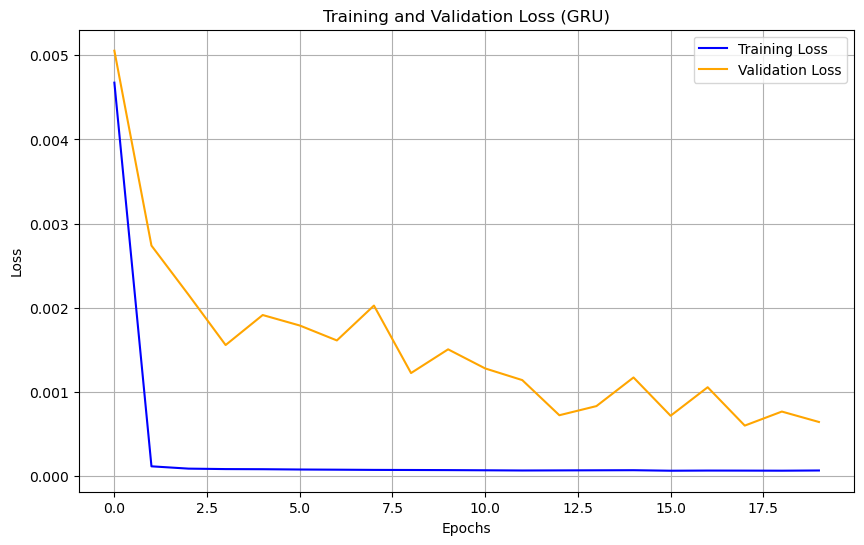

In [ ]:

class GRUModel:
    def __init__(self, input_shape):
        
        self.model = Sequential([
            GRU(32, activation='tanh', input_shape=input_shape, return_sequences=False),
            Dense(1)  
        ])
    
    def compile(self):
        
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
    
    def plot_loss(self):
        
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (GRU)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()


gru_model = GRUModel(input_shape=(X_train.shape[1], X_train.shape[2]))
gru_model.compile()
gru_model.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)


gru_model.plot_loss()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
GRU Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 0.8686112322765361
Mean Squared Error (MSE): 1.4005831841556418
Root Mean Squared Error (RMSE): 1.1834623712461845
R-squared (R2): 0.9671763336366914


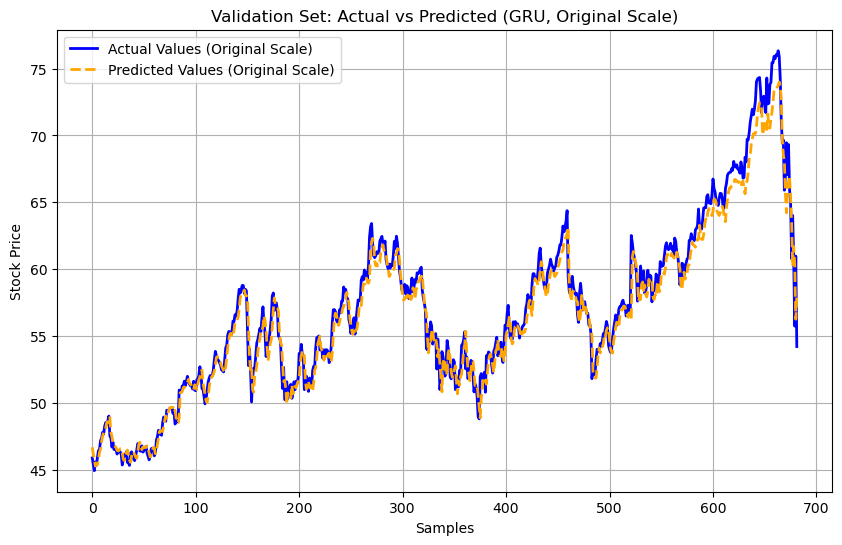

In [ ]:
y_val_pred_gru = gru_model.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_gru_reshaped = y_val_pred_gru.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped])
)[:, -1]
y_val_pred_gru_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_pred_gru_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_gru_reshaped])
)[:, -1]


mae = mean_absolute_error(y_val_inv, y_val_pred_gru_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_gru_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_gru_inv)

# Print metrics
print(f"GRU Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_gru_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (GRU, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


## Experimental analysis with exploring different hyperparameters


Epoch 1/20


/Users/tusharbansal/anaconda3/envs/UML/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0185 - mae: 0.0801 - val_loss: 0.0243 - val_mae: 0.1366
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 2.1260e-04 - mae: 0.0100 - val_loss: 0.0136 - val_mae: 0.0999
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 1.4147e-04 - mae: 0.0087 - val_loss: 0.0077 - val_mae: 0.0696
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.2107e-04 - mae: 0.0077 - val_loss: 0.0059 - val_mae: 0.0593
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 9.7587e-05 - mae: 0.0071 - val_loss: 0.0066 - val_mae: 0.0658
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1.0125e-04 - mae: 0.0072 - val_loss: 0.0048 - val_mae: 0.0540
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 8.8597e-05 - mae: 0.0069 - val_loss: 0.0043 - val_mae: 0.0502
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.0804e-04 - mae: 0.0075 - val_loss: 0.0047 - val_mae: 0.0552
Epoch 9/20
101/101 ━━━━━━━━━━━━

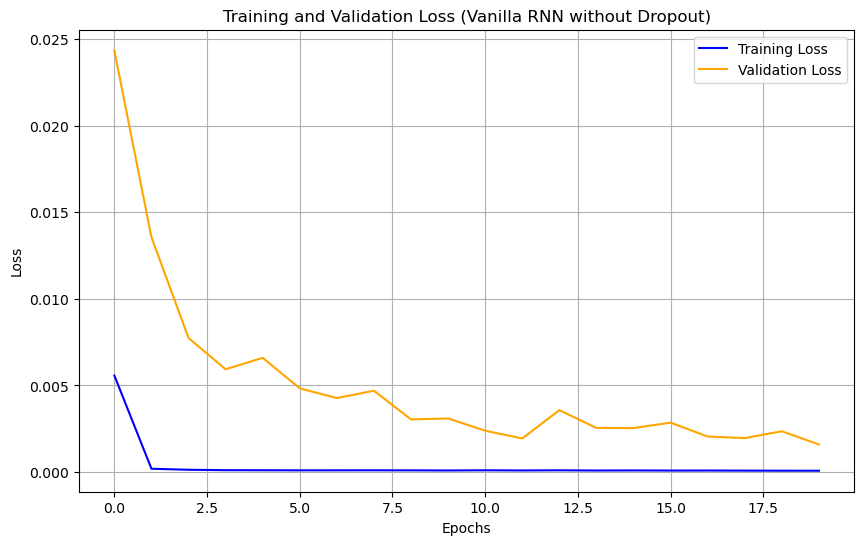

In [ ]:

class VanillaRNNHyperTuned:
    def __init__(self, input_shape, units=64, activation='tanh', learning_rate=0.001):
        
        self.model = Sequential([
            SimpleRNN(units, activation=activation, input_shape=input_shape),
            Dense(1)  
        ])
        self.learning_rate = learning_rate
    
    def compile(self):
        
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
    
    def plot_loss(self):
        
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (Vanilla RNN without Dropout)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()


units = 64  
activation = 'tanh'  
learning_rate = 0.001  
batch_size = 32  
epochs = 20  


vanilla_rnn_hypertuned = VanillaRNNHyperTuned(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=units,
    activation=activation,
    learning_rate=learning_rate
)
vanilla_rnn_hypertuned.compile()
vanilla_rnn_hypertuned.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)


vanilla_rnn_hypertuned.plot_loss()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Tuned Vanilla RNN Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 1.3767481493460467
Mean Squared Error (MSE): 3.460567221427599
Root Mean Squared Error (RMSE): 1.860259987589799
R-squared (R2): 0.9188991377385274


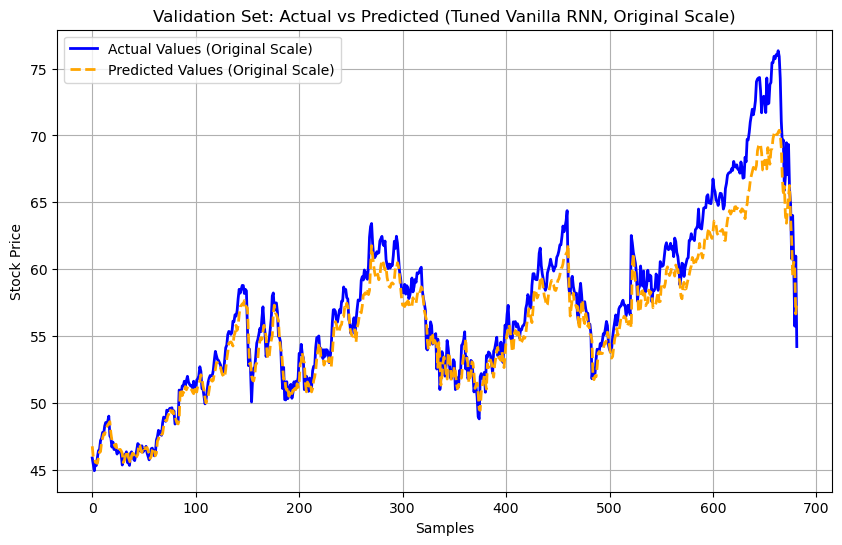

In [ ]:
y_val_pred_tuned_rnn = vanilla_rnn_hypertuned.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_tuned_rnn_reshaped = y_val_pred_tuned_rnn.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped])
)[:, -1]
y_val_pred_tuned_rnn_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_pred_tuned_rnn_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_tuned_rnn_reshaped])
)[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_tuned_rnn_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_tuned_rnn_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_tuned_rnn_inv)

# Print metrics
print(f"Tuned Vanilla RNN Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_tuned_rnn_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (Tuned Vanilla RNN, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Epoch 1/20


/Users/tusharbansal/anaconda3/envs/UML/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0272 - mae: 0.0956 - val_loss: 0.0021 - val_mae: 0.0354
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5636e-04 - mae: 0.0092 - val_loss: 0.0018 - val_mae: 0.0331
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6383e-04 - mae: 0.0092 - val_loss: 0.0019 - val_mae: 0.0337
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5498e-04 - mae: 0.0089 - val_loss: 0.0016 - val_mae: 0.0308
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5701e-04 - mae: 0.0090 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6062e-04 - mae: 0.0090 - val_loss: 0.0013 - val_mae: 0.0277
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.4967e-04 - mae: 0.0087 - val_loss: 0.0013 - val_mae: 0.0273
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6307e-04 - mae: 0.0092 - val_loss: 0.0019 - val_mae: 0.0348
Epoch 9/20
101/101 ━━━━━━━━━━━━

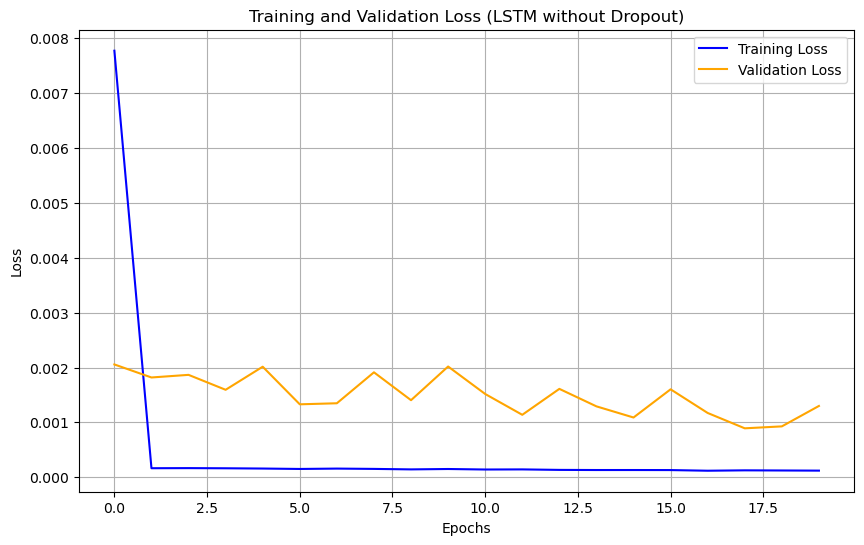

In [ ]:

class LSTM_hypertuned:
    def __init__(self, input_shape, units=64, activation='tanh', learning_rate=0.001):
        
        self.model = Sequential([
            tf.keras.layers.LSTM(units, activation=activation, input_shape=input_shape),
            Dense(1)  
        ])
        self.learning_rate = learning_rate
    
    def compile(self):
        
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
    
    def plot_loss(self):
        
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (LSTM without Dropout)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()


units = 64  
activation = 'tanh'  
learning_rate = 0.001  
batch_size = 32  
epochs = 20  


lstm_hypertuned = LSTM_hypertuned(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=units,
    activation=activation,
    learning_rate=learning_rate
)
lstm_hypertuned.compile()
lstm_hypertuned.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)


lstm_hypertuned.plot_loss()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Tuned LSTM Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 1.3647616937363252
Mean Squared Error (MSE): 2.8328152359696057
Root Mean Squared Error (RMSE): 1.6830969181748285
R-squared (R2): 0.933610953475484


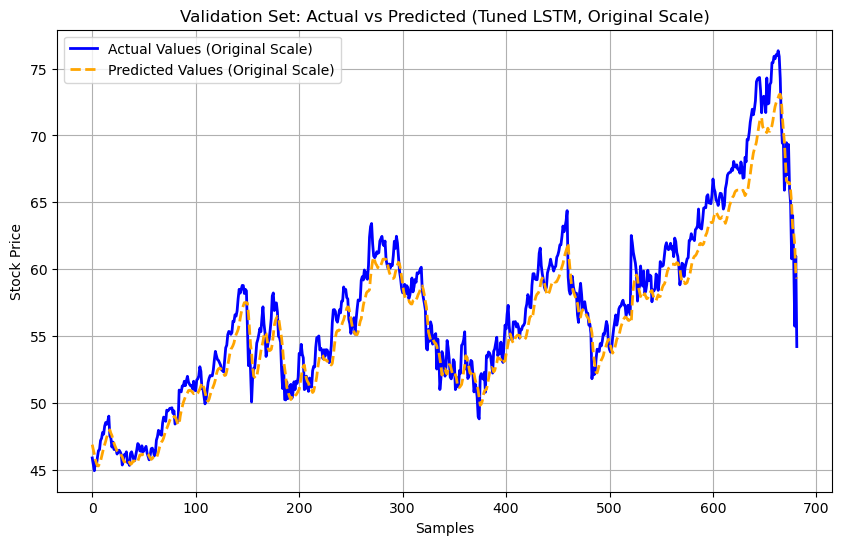

In [ ]:
y_val_pred_tuned_lstm = lstm_hypertuned.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1)  
y_val_pred_tuned_lstm_reshaped = y_val_pred_tuned_lstm.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped])
)[:, -1]
y_val_pred_tuned_lstm_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_pred_tuned_lstm_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_tuned_lstm_reshaped])
)[:, -1]


mae = mean_absolute_error(y_val_inv, y_val_pred_tuned_lstm_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_tuned_lstm_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_tuned_lstm_inv)

# Print metrics
print(f"Tuned LSTM Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_tuned_lstm_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (Tuned LSTM, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


Epoch 1/20


/Users/tusharbansal/anaconda3/envs/UML/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0626 - mae: 0.1537 - val_loss: 0.0056 - val_mae: 0.0656
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1408e-04 - mae: 0.0112 - val_loss: 0.0029 - val_mae: 0.0453
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2664e-04 - mae: 0.0081 - val_loss: 0.0016 - val_mae: 0.0325
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.9820e-05 - mae: 0.0071 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1105e-04 - mae: 0.0071 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5780e-05 - mae: 0.0068 - val_loss: 0.0014 - val_mae: 0.0298
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4839e-05 - mae: 0.0067 - val_loss: 9.0855e-04 - val_mae: 0.0234
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.8879e-05 - mae: 0.0064 - val_loss: 7.4811e-04 - val_mae: 0.0209
Epoch 9/20
101/101 ━━━━

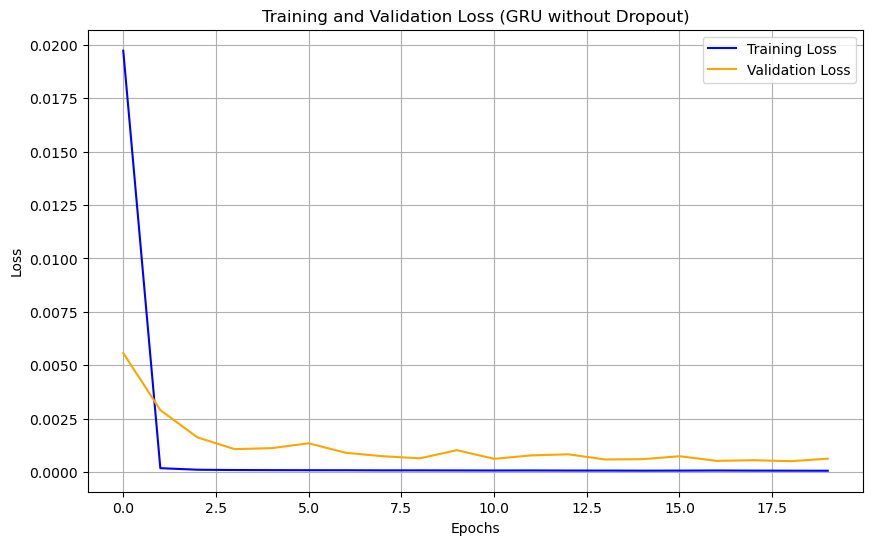

In [ ]:

class GRU_hypertuned:
    def __init__(self, input_shape, units=64, activation='tanh', learning_rate=0.001):
        
        self.model = Sequential([
            tf.keras.layers.GRU(units, activation=activation, input_shape=input_shape),
            Dense(1)  
        ])
        self.learning_rate = learning_rate
    
    def compile(self):
        
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
    
    def plot_loss(self):
        
        history = self.history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Training and Validation Loss (GRU without Dropout)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()


units = 64  
activation = 'tanh'  
learning_rate = 0.001  
batch_size = 32  
epochs = 20  


gru_hypertuned = GRU_hypertuned(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=units,
    activation=activation,
    learning_rate=learning_rate
)
gru_hypertuned.compile()
gru_hypertuned.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)


gru_hypertuned.plot_loss()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Tuned GRU Validation Metrics (Original Scale):
Mean Absolute Error (MAE): 0.8855306955376678
Mean Squared Error (MSE): 1.3814779149821905
Root Mean Squared Error (RMSE): 1.1753628865087542
R-squared (R2): 0.9676240792531066


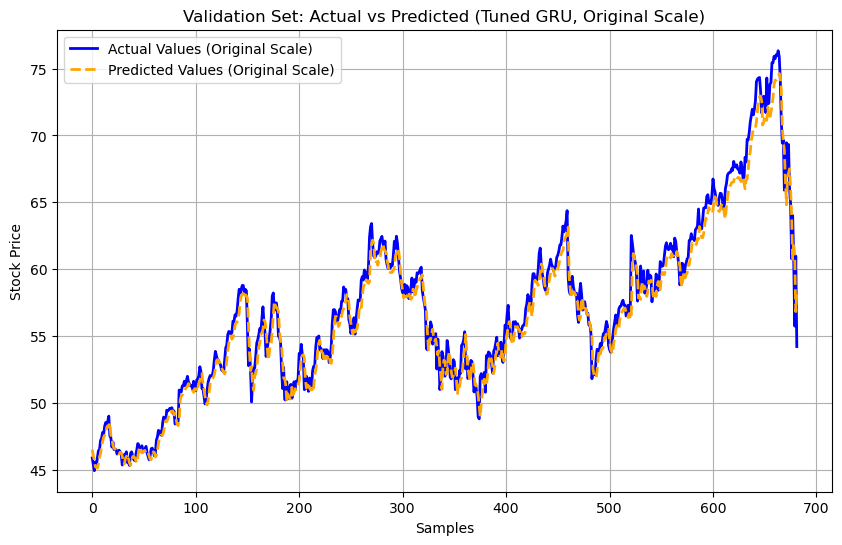

In [ ]:
y_val_pred_tuned_gru = gru_hypertuned.model.predict(X_val)

y_val_reshaped = y_val.reshape(-1, 1) 
y_val_pred_tuned_gru_reshaped = y_val_pred_tuned_gru.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_val_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_reshaped)] * (train_data.shape[1] - 1) + [y_val_reshaped])
)[:, -1]
y_val_pred_tuned_gru_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_val_pred_tuned_gru_reshaped)] * (train_data.shape[1] - 1) + [y_val_pred_tuned_gru_reshaped])
)[:, -1]

mae = mean_absolute_error(y_val_inv, y_val_pred_tuned_gru_inv)
mse = mean_squared_error(y_val_inv, y_val_pred_tuned_gru_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_val_pred_tuned_gru_inv)

# Print metrics
print(f"Tuned GRU Validation Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot Predicted vs Actual Values (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_val_pred_tuned_gru_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Validation Set: Actual vs Predicted (Tuned GRU, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


### Evaluating on the test dataset

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Tuned RNN Test Metrics (Original Scale):
Mean Absolute Error (MAE): 24.944194967096504
Mean Squared Error (MSE): 873.5945305555482
Root Mean Squared Error (RMSE): 29.556632598378798
R-squared (R2): -0.33901375110396703


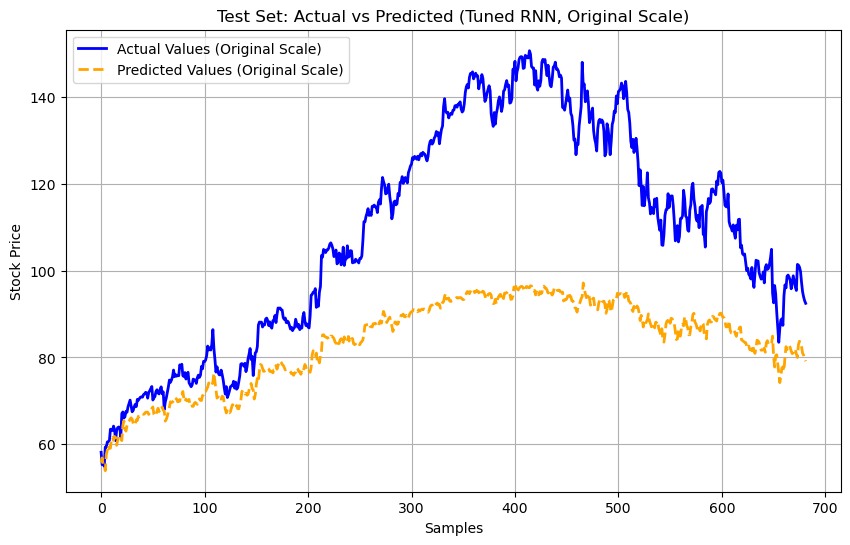

In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)  
y_test_pred_tuned_rnn = vanilla_rnn_hypertuned.model.predict(X_test).reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_reshaped)] * (train_data.shape[1] - 1) + [y_test_reshaped])
)[:, -1]
y_test_pred_tuned_rnn_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_pred_tuned_rnn)] * (train_data.shape[1] - 1) + [y_test_pred_tuned_rnn])
)[:, -1]

mae_test = mean_absolute_error(y_test_inv, y_test_pred_tuned_rnn_inv)
mse_test = mean_squared_error(y_test_inv, y_test_pred_tuned_rnn_inv)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_inv, y_test_pred_tuned_rnn_inv)

# Print test metrics
print(f"Tuned RNN Test Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R2): {r2_test}")

# Plot Predicted vs Actual Values (Test Data, Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_test_pred_tuned_rnn_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Test Set: Actual vs Predicted (Tuned RNN, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Tuned LSTM Test Metrics (Original Scale):
Mean Absolute Error (MAE): 12.402919690979541
Mean Squared Error (MSE): 222.40647619981584
Root Mean Squared Error (RMSE): 14.913298635775247
R-squared (R2): 0.6591034861713865


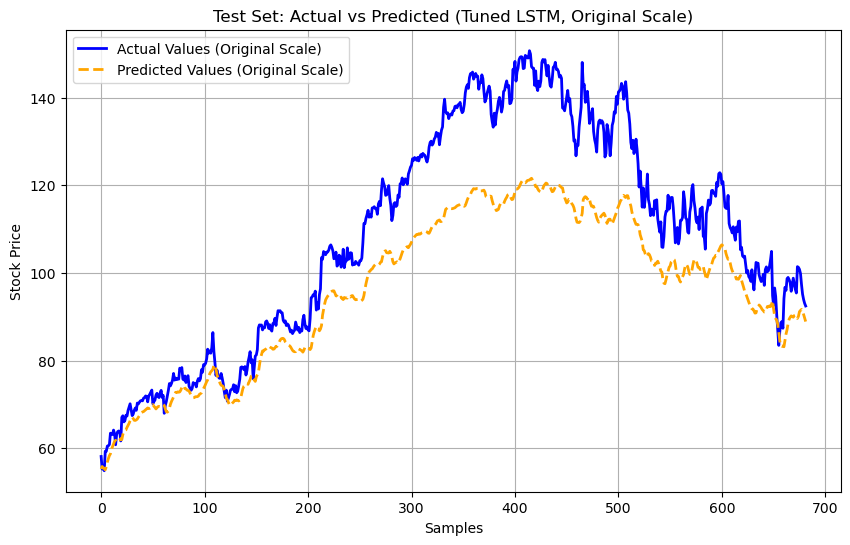

In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)  
y_test_pred_tuned_lstm = lstm_hypertuned.model.predict(X_test).reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_reshaped)] * (train_data.shape[1] - 1) + [y_test_reshaped])
)[:, -1]
y_test_pred_tuned_lstm_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_pred_tuned_lstm)] * (train_data.shape[1] - 1) + [y_test_pred_tuned_lstm])
)[:, -1]

mae_test = mean_absolute_error(y_test_inv, y_test_pred_tuned_lstm_inv)
mse_test = mean_squared_error(y_test_inv, y_test_pred_tuned_lstm_inv)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_inv, y_test_pred_tuned_lstm_inv)

# Print test metrics
print(f"Tuned LSTM Test Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R2): {r2_test}")

# Plot Predicted vs Actual Values (Test Data, Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_test_pred_tuned_lstm_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Test Set: Actual vs Predicted (Tuned LSTM, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Tuned GRU Test Metrics (Original Scale):
Mean Absolute Error (MAE): 8.873082779020159
Mean Squared Error (MSE): 119.53650965394614
Root Mean Squared Error (RMSE): 10.933275339711615
R-squared (R2): 0.8167788091761314


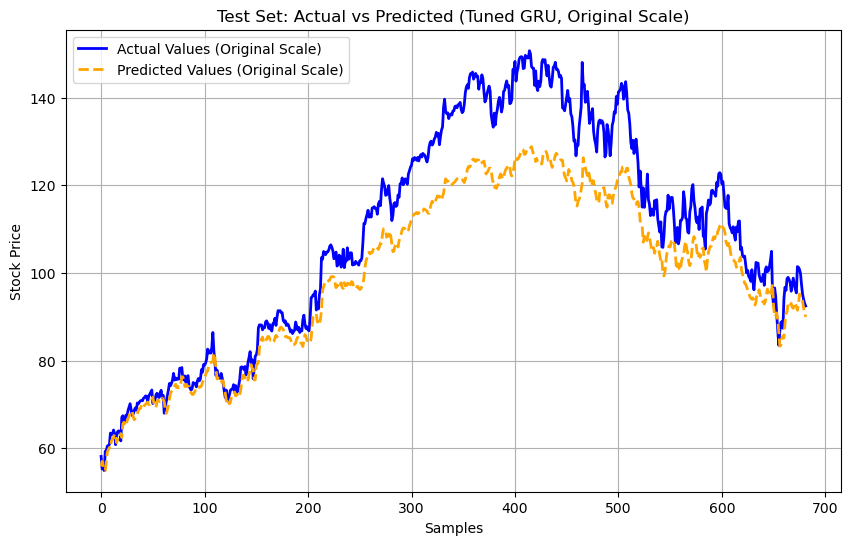

In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)  
y_test_pred_tuned_gru = gru_hypertuned.model.predict(X_test).reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_reshaped)] * (train_data.shape[1] - 1) + [y_test_reshaped])
)[:, -1]
y_test_pred_tuned_gru_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_pred_tuned_gru)] * (train_data.shape[1] - 1) + [y_test_pred_tuned_gru])
)[:, -1]

mae_test = mean_absolute_error(y_test_inv, y_test_pred_tuned_gru_inv)
mse_test = mean_squared_error(y_test_inv, y_test_pred_tuned_gru_inv)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_inv, y_test_pred_tuned_gru_inv)

# Print test metrics
print(f"Tuned GRU Test Metrics (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R2): {r2_test}")

# Plot Predicted vs Actual Values (Test Data, Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Values (Original Scale)', color='blue', linewidth=2)
plt.plot(y_test_pred_tuned_gru_inv, label='Predicted Values (Original Scale)', color='orange', linewidth=2, linestyle='dashed')
plt.title('Test Set: Actual vs Predicted (Tuned GRU, Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
     Actual Close (Original Scale)  Predicted Close (Original Scale) Signal
0                        58.140499                         55.969879   None
1                        55.280998                         57.011608   None
2                        56.042000                         55.574299   None
3                        54.894001                         55.210289   None
4                        59.346001                         54.874733   None
5                        59.325500                         56.983200   None
6                        60.514000                         59.115566   None
7                        60.572498                         59.712193   None
8                        60.877998                         60.168125   None
9                        63.461498                         59.995296   None
10                       63.123501                         61.770134   Hold
11                       63.173500              

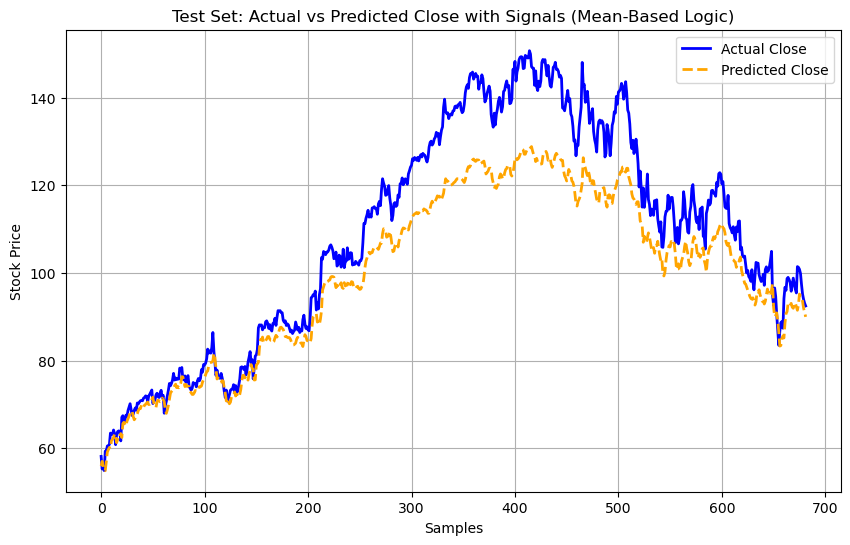

In [ ]:
y_test_pred = gru_hypertuned.model.predict(X_test) 

y_test_reshaped = y_test.reshape(-1, 1)
y_test_pred_reshaped = y_test_pred.reshape(-1, 1)

# Perform inverse transformation on just the Close column
y_test_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_reshaped)] * (train_data.shape[1] - 1) + [y_test_reshaped])
)[:, -1]
y_test_pred_inv = scaler.inverse_transform(
    np.hstack([np.zeros_like(y_test_pred_reshaped)] * (train_data.shape[1] - 1) + [y_test_pred_reshaped])
)[:, -1]

# Generate signals using the mean of the past 10 days' actual prices
signals = []
for i in range(len(y_test_inv) - 10):  
    past_10_mean = np.mean(y_test_inv[i:i+10])  
    predicted_price = y_test_pred_inv[i+10]  

    # Calculate percentage change
    percentage_change = ((predicted_price - past_10_mean) / past_10_mean) * 100

    # Generate the signal based on the percentage change
    if percentage_change > 5:
        signals.append("Buy")
    elif percentage_change < -5:
        signals.append("Sell")
    else:
        signals.append("Hold")

signals = [None] * 10 + signals

# Combine into a DataFrame for output
results = pd.DataFrame({
    'Actual Close (Original Scale)': y_test_inv,
    'Predicted Close (Original Scale)': y_test_pred_inv,
    'Signal': signals
})

# Display the first few rows of the results
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)  
pd.set_option('display.max_rows', None)  
print(results)

# Visualize the predicted vs actual closing prices with signals
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Close', color='blue', linewidth=2)
plt.plot(y_test_pred_inv, label='Predicted Close', color='orange', linestyle='dashed', linewidth=2)
plt.title('Test Set: Actual vs Predicted Close with Signals (Mean-Based Logic)')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


### Graph of Stock Price Distribution

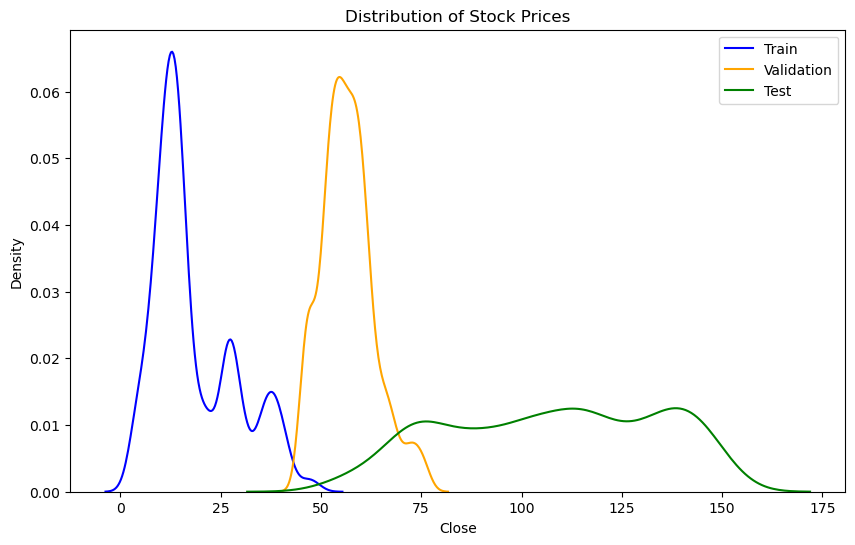

In [29]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(train_data['Close'], label='Train', color='blue')
sns.kdeplot(validation_data['Close'], label='Validation', color='orange')
sns.kdeplot(test_data['Close'], label='Test', color='green')
plt.title('Distribution of Stock Prices')
plt.legend()
plt.show()
